# Compute Antarctic, depth integrated, cross slope heat transport, online terms


Skrip is based on Adele's code. Adapted for monthly data and using ty_trans (see explanation below).

### Calculate heat transports using MOM5 model output:

MOM calcualted heat flux online: `temp_yflux` 
- unit us `[W]`
- calculated as `cp*rho*dz*dx*v*T = [Ws/kg/K kg/m3 m m m/s K] = [W]`

Problem with above solution is that we want heat flux related to above freezing point water, so need to find a way to compute that separately, either using `uhrho`/`vhrho` or `ty_trans`/`tx_trans` and then subract from full heat transport.

A. Calculate heat flux using `uhrho` and `vhrho`
- unit is `[kg/m3 m3/s]`
- multiply with `vhrho * cp * dx * T = [kg/m3 m2/s Ws/kg/K m K] = [W]`

B. Calculate heat flux using `ty_trans` and `tx_trans`:
- unit is `[kg/s]`
- mutliply with `ty_trans * cp * T = [kg/s Ws/kg/K K] = [W]`
- (`ty_trans = vhrho * dxu`)

In [1]:
%matplotlib inline

import cosima_cookbook as cc
from cosima_cookbook import distributed as ccd
import matplotlib.pyplot as plt
import numpy as np
import netCDF4 as nc
import xarray as xr
import glob,os
import cmocean.cm as cmocean

import logging
logging.captureWarnings(True)
logging.getLogger('py.warnings').setLevel(logging.ERROR)

from dask.distributed import Client

In [2]:
#client = Client(n_workers=4)
# >> dask-scheduler
# >> dask-worker tcp://10.0.64.9:8786 --memory-limit 4e9 --nprocs 6 --nthreads 1 --local-directory /local/g40/amh157
#client = Client('tcp://10.0.64.9:8786', local_dir='/local/g40/amh157')
client = Client()
client

Client Scheduler: tcp://127.0.0.1:44583 Dashboard: /proxy/34825/status,Cluster Workers: 4 Cores: 8 Memory: 200.00 GiB


In [3]:
# database for control simulation:
master_session = cc.database.create_session('/g/data/ik11/databases/cosima_master.db')
control = '01deg_jra55v13_ryf9091'

# database for perturbations:
easterlies_session = cc.database.create_session('/g/data/v45/akm157/model_data/access-om2/01deg_jra55v13_ryf9091_easterlies_up10/easterlies.db')
# 10% increase in easterly wind speed:
easterlies_up = '01deg_jra55v13_ryf9091_easterlies_up10'
# 10% decrease in easterly wind speed:
easterlies_down = '01deg_jra55v13_ryf9091_easterlies_down10'

# First year
year = '2150'
start_time='2150-01-01'
end_time='2150-12-31'
time_period = str(int(start_time[:4]))+'-'+str(int(end_time[:4]))

In [4]:
# reference density value:
rho_0 = 1035.0
# specific heat capacity of sea water:
cp = 3992.1
lat_range = slice(-90,-59)

isobath_depth = 1000

# pick a freezing point temp:
temp_freezing = -2.5

## Open contour data, extract lat/lon on contour

In [5]:
outfile = '/g/data/v45/akm157/model_data/access-om2/Antarctic_slope_contour_'+str(isobath_depth)+'m.npz'
data = np.load(outfile)
mask_y_transport = data['mask_y_transport']
mask_x_transport = data['mask_x_transport']
mask_y_transport_numbered = data['mask_y_transport_numbered']
mask_x_transport_numbered = data['mask_x_transport_numbered']

yt_ocean = cc.querying.getvar(control,'yt_ocean',master_session,n=1)
yt_ocean = yt_ocean.sel(yt_ocean=lat_range)
yu_ocean = cc.querying.getvar(control,'yu_ocean',master_session,n=1)
yu_ocean = yu_ocean.sel(yu_ocean=lat_range)
xt_ocean = cc.querying.getvar(control,'xt_ocean',master_session,n=1)
xu_ocean = cc.querying.getvar(control,'xu_ocean',master_session,n=1)

# convert isobath masks to data arrays, so we can multiply them later:
mask_x_transport = xr.DataArray(mask_x_transport, coords = [('yt_ocean', yt_ocean), ('xu_ocean', xu_ocean)])
mask_y_transport = xr.DataArray(mask_y_transport, coords = [('yu_ocean', yu_ocean), ('xt_ocean', xt_ocean)])
mask_x_transport_numbered = xr.DataArray(mask_x_transport_numbered, coords = [('yt_ocean', yt_ocean), ('xt_ocean', xt_ocean)])
mask_y_transport_numbered = xr.DataArray(mask_y_transport_numbered, coords = [('yt_ocean', yt_ocean), ('xt_ocean', xt_ocean)])

num_points = int(np.maximum(np.max(mask_y_transport_numbered),np.max(mask_x_transport_numbered)))

In [16]:
data.files

['contour_mask_numbered',
 'contour_masked_above',
 'contour_depth',
 'xt_ocean',
 'yt_ocean',
 'mask_y_transport',
 'mask_x_transport',
 'mask_y_transport_numbered',
 'mask_x_transport_numbered']

In [21]:
cmn=data['contour_mask_numbered']
cmn.shape

(510, 3600)

In [6]:
lat_along_contour = np.zeros((num_points))
lon_along_contour = np.zeros((num_points))

# locations for zonal transport:
x_indices_masked = mask_x_transport_numbered.stack().values
x_indices = np.sort(x_indices_masked[x_indices_masked>0])
for count in x_indices:
    count = int(count)
    jj = int(np.where(mask_x_transport_numbered==count)[0])
    ii = int(np.where(mask_x_transport_numbered==count)[1])   
    lon_along_contour[count-1] = xu_ocean[ii].values
    lat_along_contour[count-1] = mask_x_transport_numbered.yt_ocean[jj].values
    
# locations for meridional transport:
y_indices_masked = mask_y_transport_numbered.stack().values
y_indices = np.sort(y_indices_masked[y_indices_masked>0])
for count in y_indices:
    count = int(count)
    jj = np.where(mask_y_transport_numbered==count)[0]
    ii = np.where(mask_y_transport_numbered==count)[1]
    lon_along_contour[count-1] = mask_x_transport_numbered.xt_ocean[ii].values
    lat_along_contour[count-1] = yu_ocean[jj].values

In [7]:
lat_along_contour

array([-66.00806249, -66.00806249, -66.00806249, ..., -66.05030184,
       -66.05030184, -66.02918216])

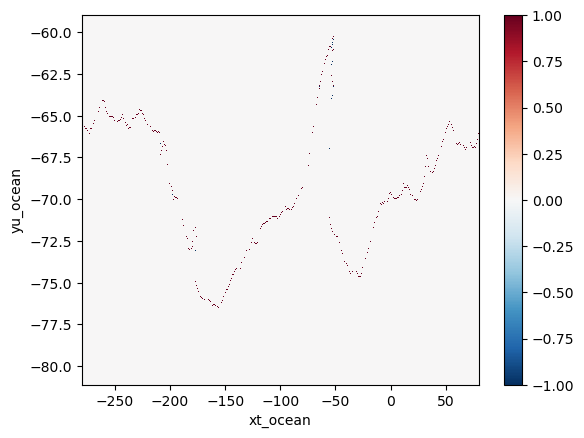

In [24]:
mask_y_transport.plot()

## Compute heat transports calculated online

In [34]:
# Note temp_yflux_adv is also positioned on north centre edge of t-cell.
# temp_yflux_adv = cp*rho*dzt*dxt*v*temp

def import_temp_flux(exp):
    """
    0: control
    1: UP
    2: DOWN
    """
    if exp == 0:
        temp_yflux_tmp = cc.querying.getvar(control, 'temp_yflux_adv', master_session, start_time=start_time, end_time=end_time)
        temp_xflux_tmp = cc.querying.getvar(control, 'temp_xflux_adv', master_session, start_time=start_time, end_time=end_time)
    elif exp == 1:
        temp_yflux_tmp = cc.querying.getvar(easterlies_up, 'temp_yflux_adv', easterlies_session, frequency='1 monthly', start_time=start_time, end_time=end_time) 
        temp_xflux_tmp = cc.querying.getvar(easterlies_up, 'temp_xflux_adv', easterlies_session, frequency='1 monthly', start_time=start_time, end_time=end_time)
    elif exp == 2:
        temp_yflux_tmp = cc.querying.getvar(easterlies_down, 'temp_yflux_adv', easterlies_session, frequency='1 monthly', start_time=start_time, end_time=end_time)
        temp_xflux_tmp = cc.querying.getvar(easterlies_down, 'temp_xflux_adv', easterlies_session, frequency='1 monthly', start_time=start_time, end_time=end_time)
    # select latitude range:
    temp_yflux_tmp = temp_yflux_tmp.sel(yu_ocean=lat_range).sel(time=slice(start_time,end_time))
    temp_xflux_tmp = temp_xflux_tmp.sel(yt_ocean=lat_range).sel(time=slice(start_time,end_time))
    # Finished
    return temp_yflux_tmp, temp_xflux_tmp

In [35]:
temp_yflux, temp_xflux = import_temp_flux(0)
temp_yflux

,Array,Chunk
Bytes,6.16 GiB,3.20 MiB
Shape,"(12, 75, 510, 3600)","(1, 7, 300, 400)"
Count,32081 Tasks,2376 Chunks
Type,float32,numpy.ndarray


Depth integral (select certain depth range, optional)

In [27]:
# time average and sum in depth:
# temp_yflux = temp_yflux.mean('time').sum('st_ocean')
# temp_xflux = temp_xflux.mean('time').sum('st_ocean')

# optional, select only certain depth levels
depth_flag = 1
if depth_flag == 1:
    # Adjust depth levels as you want
    temp_yflux = temp_yflux.sel(st_ocean=slice(200, 1500))
    temp_xflux = temp_xflux.sel(st_ocean=slice(200, 1500))

# Depth integral
temp_yflux = temp_yflux.sum('st_ocean')
temp_xflux = temp_xflux.sum('st_ocean')

temp_yflux = temp_yflux.load()
temp_xflux = temp_xflux.load()

In [28]:
# yt_ocean = cc.querying.getvar(control,'yt_ocean',master_session,n=1)
# dxu = cc.querying.getvar(control,'dxu',master_session,n=1)
# dyt = cc.querying.getvar(control,'dyt', master_session,n=1)
# # give dxu and dyt correct coordinates:
# dxu.coords['nj'] = yt_ocean.values
# dxu.coords['ni'] = xt_ocean['xt_ocean'].values
# dxu = dxu.rename(({'ni':'xt_ocean', 'nj':'yt_ocean'}))
# dyt.coords['nj'] = yt_ocean.values
# dyt.coords['ni'] = xt_ocean['xt_ocean'].values
# dyt = dyt.rename(({'ni':'xt_ocean', 'nj':'yt_ocean'}))
# # select latitude range:
# dxu = dxu.sel(yt_ocean=lat_range)
# dyt = dyt.sel(yt_ocean=lat_range)

In [36]:
def import_feezing_transport(exp):
    """
    0: control
    1: UP
    2: DOWN
    """
    # USe ty_trans and tx_trans as vhrho_nt and uhrho_et is not available for time of interest
    if exp == 0:
        ty_trans = cc.querying.getvar(control, 'ty_trans', master_session, start_time=start_time, end_time=end_time)
        tx_trans = cc.querying.getvar(control, 'tx_trans', master_session, start_time=start_time, end_time=end_time)
    elif exp == 1:
        ty_trans = cc.querying.getvar(easterlies_up,'ty_trans', easterlies_session, start_time=start_time, end_time=end_time)
        tx_trans = cc.querying.getvar(easterlies_up,'tx_trans', easterlies_session, start_time=start_time, end_time=end_time)
    elif exp == 2:
        ty_trans = cc.querying.getvar(easterlies_down, 'ty_trans', easterlies_session, start_time=start_time, end_time=end_time)
        tx_trans = cc.querying.getvar(easterlies_down, 'tx_trans', easterlies_session, start_time=start_time, end_time=end_time)
    # select latitude range:
    ty_trans = ty_trans.sel(yu_ocean=lat_range).sel(time=slice(start_time,end_time))
    tx_trans = tx_trans.sel(yt_ocean=lat_range).sel(time=slice(start_time,end_time))
    
    
    # sum in depth:
    if depth_flag == 1:
        ty_trans = ty_trans.sel(st_ocean=slice(200, 1500))
        tx_trans = tx_trans.sel(st_ocean=slice(200, 1500))
    ty_trans = ty_trans.sum('st_ocean')
    tx_trans = tx_trans.sum('st_ocean')
    # convert to transport:
    ty_trans = ty_trans/rho_0 # This step is a little silly, as we multiply with rho_0 again in the next step.
    tx_trans = tx_trans/rho_0
    # Note vhrho_nt is v*dz*1035 and is positioned on north centre edge of t-cell.
    #vhrho_nt = vhrho_nt*dxu/rho_0
    #uhrho_et = uhrho_et*dyt/rho_0
    
    # overwrite coords, so we can add the freezing point (with uhrho_et and vhrho_nt) without problems:
    #yu_ocean = cc.querying.getvar(exp,'yu_ocean',session,n=1)
    #yu_ocean = yu_ocean.sel(yu_ocean=lat_range)
    #vhrho_nt.coords['yt_ocean'] = yu_ocean.values
    #vhrho_nt = vhrho_nt.rename(({'yt_ocean':'yu_ocean'}))
    #uhrho_et.coords['xt_ocean'] = xu_ocean.values
    #uhrho_et = uhrho_et.rename(({'xt_ocean':'xu_ocean'}))
    
    freezing_point_heat_trans_zonal_tmp      = cp*rho_0*tx_trans*temp_freezing
    freezing_point_heat_trans_meridional_tmp = cp*rho_0*ty_trans*temp_freezing
    
    # Finished
    return freezing_point_heat_trans_zonal_tmp, freezing_point_heat_trans_meridional_tmp

In [37]:
freezing_point_heat_trans_zonal, freezing_point_heat_trans_meridional = import_feezing_transport(0)

In [38]:
# compare both ways:
temp_yflux = temp_yflux - freezing_point_heat_trans_meridional
temp_xflux = temp_xflux - freezing_point_heat_trans_zonal

temp_yflux = temp_yflux.load()
temp_xflux = temp_xflux.load()

# multiply by isobath contour masks:
temp_yflux_with_mask = temp_yflux*mask_y_transport
temp_xflux_with_mask = temp_xflux*mask_x_transport

## Extract heat transport values along isobath contour:

In [41]:
temp_yflux_with_mask

<xarray.DataArray (time: 12, st_ocean: 75, yu_ocean: 510, xt_ocean: 3600)>
array([[[[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         ...,
         [ 0.,  0.,  0., ...,  0.,  0.,  0.],
         [ 0.,  0.,  0., ...,  0.,  0.,  0.],
         [ 0.,  0.,  0., ...,  0.,  0.,  0.]],

        [[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         ...,
         [ 0.,  0.,  0., ...,  0.,  0.,  0.],
         [ 0.,  0.,  0., ...,  0.,  0.,  0.],
         [ 0.,  0.,  0., ...,  0.,  0.,  0.]],

        [[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         ...,
...
         ...,
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan]],

        [[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         ...,
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan]],

        [[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         ...,
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan]]]], dtype=float32)
Coordinates:
  * xt_ocean  (xt_ocean) float64 -279.9 -279.8 -279.7 ... 79.75 79.85 79.95
  * st_ocean  (st_ocean) float64 0.5413 1.681 2.94 ... 5.511e+03 5.709e+03
  * time      (time) object 2150-01-16 12:00:00 ... 2150-12-16 12:00:00
  * yu_ocean  (yu_ocean) float64 -81.09 -81.05 -81.0 ... -59.11 -59.06 -59.01

In [40]:
# multiply by mask to get correct direction into or out of isobath contour:
heat_trans_across_contour = np.zeros((12,num_points))

# locations for zonal transport, already calculated indices above:
for count in x_indices:
    count = int(count)
    jj = int(np.where(mask_x_transport_numbered==count)[0])
    ii = int(np.where(mask_x_transport_numbered==count)[1])
    heat_trans_across_contour[:,count-1] += temp_xflux_with_mask[:,jj,ii].values
    
# locations for meridional transport, already calculated indices above:
for count in y_indices:
    count = int(count)
    jj = int(np.where(mask_y_transport_numbered==count)[0])
    ii = int(np.where(mask_y_transport_numbered==count)[1])
    heat_trans_across_contour[:,count-1] += temp_yflux_with_mask[:,jj,ii].values

IndexError: index 358 is out of bounds for axis 1 with size 75

## Convert cross-slope heat transport from isobath coordinate to longitude coordinate

In [34]:
# convert to longitude coordinate and average into 3 degree longitude bins:

# in degrees:
bin_width = 3
bin_spacing = 0.25
lon_west = -280
lon_east = 80

# new coordinate and midpoints of longitude bins:
full_lon_coord = np.arange(lon_west,lon_east+bin_spacing,bin_spacing)
lon_bin_midpoints = np.arange(lon_west+bin_width/2,lon_east-bin_width/2,bin_spacing)
n_bin_edges = len(full_lon_coord)

# sum into longitude bins:
# need to be very careful of loops, we can't just mask over longitude values, but instead pick indices 
# on the isobath contour and sum continously along contour between defined indices.
# (i.e. lon_along_contour is not monotonic)
# find points on contour to define edges of longitude bins:
bin_edge_indices = np.zeros(n_bin_edges)
for lon_bin in range(n_bin_edges-1):
    # find first isobath point that has the right longitude:
    first_point = np.where(lon_along_contour>=full_lon_coord[lon_bin])[0][0]
    # then find all other isobath points with the same longitude as that first point:
    same_lon_points = np.where(lon_along_contour==lon_along_contour[first_point])[0]
    # we want the most southerly of these points on the same longitude line:
    bin_edge_indices[lon_bin] = same_lon_points[np.argmin(lat_along_contour[same_lon_points])]
    
# define east/west edges:
bin_edge_indices = bin_edge_indices.astype(int)
bin_edge_indices_west = bin_edge_indices[:-int(bin_width/bin_spacing)-1]
bin_edge_indices_east = bin_edge_indices[int(bin_width/bin_spacing):-1]
n_bins = len(bin_edge_indices_west)

# sum heat transport from isobath coord into new longitude coord:
cross_slope_heat_trans = np.zeros((12,n_bins))
for lon_bin in range(n_bins):
    heat_trans_this_bin = heat_trans_across_contour[:,bin_edge_indices_west[lon_bin]:bin_edge_indices_east[lon_bin]]
    cross_slope_heat_trans[:,lon_bin] = np.sum(heat_trans_this_bin, axis=1)
    
# find average latitude of each bin, so we can plot back on the isobath:
lat_bin_midpoints = np.zeros(n_bins)
for lon_bin in range(n_bins):
    # find nearest isobath point:
    lon_index = np.where(lon_along_contour>=lon_bin_midpoints[lon_bin])[0][0]
    lat_bin_midpoints[lon_bin] = lat_along_contour[lon_index]

## Zonal heat convergence

In [35]:
# Need to make sure the zonal boundaries here match exactly with the zonal boundaries used for the 
# longitude averaging above, by using same bin_edge_indices.
# Just check if isobath point is on x or y grid. if x, sum up to this point from south.
# if on y grid, sum zonal transport on nearest u grid point to west.

zonal_heat_trans_west = np.zeros((12,n_bins))
for lon_bin in range(n_bins):
    # west limit:
    # reset these to False:
    on_x_grid = False
    on_y_grid = False
    # mask_x_transport_numbered etc indexing starts from 1 not 0, so add 1:
    isobath_west_index = int(bin_edge_indices_west[lon_bin]+1)
    # check if the point is on the x or y transport grid:
    if len(np.where(mask_x_transport_numbered==isobath_west_index)[0])>0:
        on_x_grid = True
        jj = int(np.where(mask_x_transport_numbered==isobath_west_index)[0])
        ii = int(np.where(mask_x_transport_numbered==isobath_west_index)[1])
    elif len(np.where(mask_y_transport_numbered==isobath_west_index)[0])>0:
        on_y_grid = True
        jj = int(np.where(mask_y_transport_numbered==isobath_west_index)[0])
        ii = int(np.where(mask_y_transport_numbered==isobath_west_index)[1])
    if on_x_grid == True:
        zonal_heat_trans_west[:,lon_bin] = np.sum(temp_xflux[:,:jj,ii], axis=1)
    # in this case we want transport half a grid point to the west:
    elif on_y_grid == True:
        # careful if ii=0, then we need heat trans from lon=80, because at limit of zonal grid
        if ii==0:
            zonal_heat_trans_west[:,lon_bin] = np.sum(temp_xflux[:,:jj+1,-1], axis=1)
        else:
            zonal_heat_trans_west[:,lon_bin] = np.sum(temp_xflux[:,:jj+1,ii-1], axis=1)

zonal_heat_trans_east = np.zeros((12,n_bins))
for lon_bin in range(n_bins):
    # east limit:
    # reset these to False:
    on_x_grid = False
    on_y_grid = False
    # mask_x_transport_numbered etc indexing starts from 1 not 0, so add 1:
    isobath_east_index = int(bin_edge_indices_east[lon_bin]+1)
    # check if the point is on the x or y transport grid:
    if len(np.where(mask_x_transport_numbered==isobath_east_index)[0])>0:
        on_x_grid = True
        jj = int(np.where(mask_x_transport_numbered==isobath_east_index)[0])
        ii = int(np.where(mask_x_transport_numbered==isobath_east_index)[1])
    elif len(np.where(mask_y_transport_numbered==isobath_east_index)[0])>0:
        on_y_grid = True
        jj = int(np.where(mask_y_transport_numbered==isobath_east_index)[0])
        ii = int(np.where(mask_y_transport_numbered==isobath_east_index)[1])
    if on_x_grid == True:
        zonal_heat_trans_east[:,lon_bin] = np.sum(temp_xflux[:,:jj,ii], axis=1)
    # in this case we want transport half a grid point to the west:
    elif on_y_grid == True:
        # wrap around to east side of grid:
        if ii==0:
            zonal_heat_trans_east[:,lon_bin] = np.sum(temp_xflux[:,:jj+1,-1], axis=1)
        else:
            zonal_heat_trans_east[:,lon_bin] = np.sum(temp_xflux[:,:jj+1,ii-1], axis=1)

zonal_convergence = zonal_heat_trans_east - zonal_heat_trans_west

## Save cross-slope and zonal convergence terms for this isobath

In [36]:
# convert to data arrays, so we can save as netcdf:
zonal_convergence = xr.DataArray(zonal_convergence, coords = ([('time', temp_yflux.time), ('lon_bin_midpoints', lon_bin_midpoints)]))
cross_slope_heat_trans = xr.DataArray(cross_slope_heat_trans, coords = [('time', temp_yflux.time), ('lon_bin_midpoints', lon_bin_midpoints)])
heat_trans_across_contour = xr.DataArray(heat_trans_across_contour,coords = [('time', temp_yflux.time), ('lon_along_contour',lon_along_contour)])

In [37]:
exp = ['control', 'UP', 'DOWN']

if depth_flag == 1:
    outpath = '/g/data/x77/wgh581/Post_Process/easterlies_hackathon_postprocess/Ant_cross_slope_heat_terms_online_'+str(isobath_depth)+'m_'+time_period+'_'+exp[0]+'_200m_bottom.nc'
else:
    outpath = '/g/data/x77/wgh581/Post_Process/easterlies_hackathon_postprocess/Ant_cross_slope_heat_terms_online_'+str(isobath_depth)+'m_'+time_period+'_'+exp[0]+'.nc'

ds = xr.Dataset({'zonal_convergence': zonal_convergence,'cross_slope_heat_trans':cross_slope_heat_trans,
                'lon_bin_midpoints':lon_bin_midpoints,'lat_bin_midpoints':lat_bin_midpoints,
                 'bin_width':bin_width,'bin_spacing':bin_spacing,'heat_trans_across_contour':heat_trans_across_contour,
                'lon_along_contour':lon_along_contour})
ds.to_netcdf(outpath)